In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras

In [2]:
def normalize(x):
    return np.array(x) / 3000

In [4]:
resolution = 28

input_data_files = ['caroni_negative',
                    'caroni_positive',
                    'additional_negative',
                    'v1_caroni_0.95_thresh',
                    'v1_caroni_0.4-0.5_thresh',
                    'tapajos_v3_0.48-0.5_69',
                    'tapajos_v3_0.4-0.6_121',
                    'tapajos_v4_0.7-0.9_235',
                    'tapajos_2016_cloudy_outliers_190',
                    'tapajos_2016_outliers_187',
                    'corrupted',
                    'amazonas_north_v6-2020_thresh_0.1_0.3-1_170',
                    'amazonas_north_v6-2020_thresh_0.1_0.5-1_154',
                    'amazonas_north_v6-2020_thresh_0.1_0.8-1_125'
                   ]

images = np.zeros((0, resolution, resolution, 12))
labels = []
for fname in input_data_files:
    images_fname = str(resolution) + '_px_' + fname + '_images.pkl'
    labels_fname = str(resolution) + '_px_' + fname + '_labels.pkl'
    with open('../data/caroni_train/' + images_fname, 'rb') as f:
        images = np.concatenate((images, pickle.load(f)))
    with open('../data/caroni_train/' + labels_fname, 'rb') as f:
        labels = np.concatenate((labels, pickle.load(f)))

print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

4562 samples loaded
597 positive samples
3965 negative samples


In [5]:
x = normalize(images)
y = labels
x, y = shuffle(x, y, random_state=22)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 4105
Num Test:		 457
Percent Negative Train:	 86.7
Percent Negative Test:	 89.3


In [7]:
model = keras.models.load_model('../models/28_px_v7.h5')

In [78]:
model_v5 = keras.models.load_model('../models/28_px_v5.h5')

In [124]:
test_dataset = x_train
test_labels = y_train[:,1]

In [125]:
preds = model.predict(test_dataset)[:,1]
preds_v5 = model_v5.predict(test_dataset)[:,1]

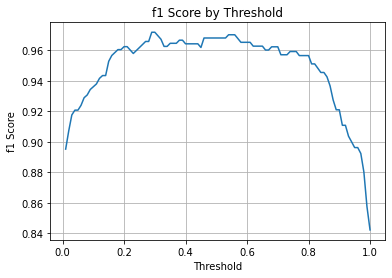

In [121]:
from sklearn.metrics import f1_score, precision_recall_curve
f1 = []
thresholds = []
for threshold in range(1, 100 + 1):
    threshold /= 100
    thresholds.append(threshold)
    binary_preds = [pred > threshold for pred in preds]
    f1.append(f1_score(test_labels, binary_preds, average='weighted'))
    
plt.plot(thresholds, f1)
plt.grid()
plt.title('f1 Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('f1 Score')
plt.show()

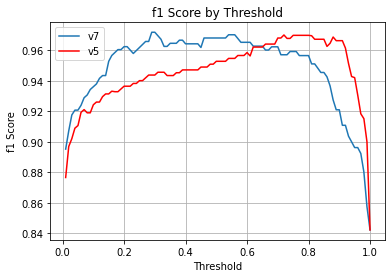

In [122]:
f1_v5 = []
thresholds_v5 = []
for threshold in range(1, 100 + 1):
    threshold /= 100
    thresholds_v5.append(threshold)
    binary_preds = [pred > threshold for pred in preds_v5]
    f1_v5.append(f1_score(test_labels, binary_preds, average='weighted'))
    
plt.plot(thresholds, f1, label='v7')
plt.plot(thresholds_v5, f1_v5, c='r', label='v5')
plt.grid()
plt.title('f1 Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('f1 Score')
plt.legend()
plt.show()

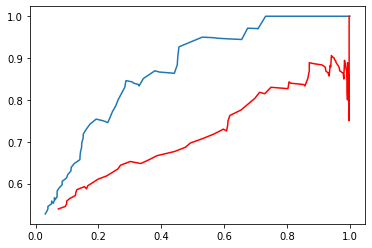

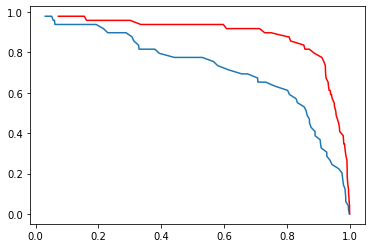

In [116]:
plt.plot(thresholds, precision[1:])
plt.plot(thresholds_v5, precision_v5[1:], c='r')
plt.show()
plt.plot(thresholds, recall[1:])
plt.plot(thresholds_v5, recall_v5[1:], c='r')

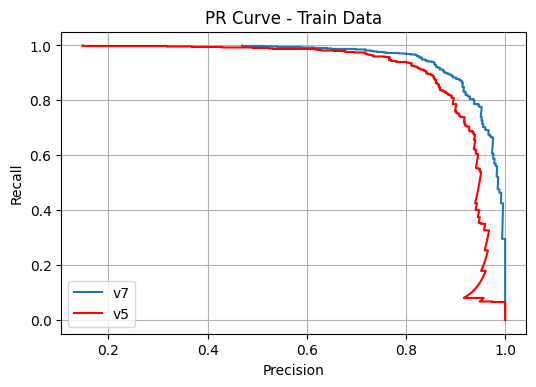

In [127]:
precision, recall, thresholds = precision_recall_curve(test_labels, preds)
precision_v5, recall_v5, thresholds_v5 = precision_recall_curve(test_labels, preds_v5)
plt.figure(dpi=100, facecolor=(1,1,1))
plt.plot(precision, recall, label='v7')
plt.plot(precision_v5, recall_v5, c='r', label='v5')
plt.grid()
plt.title('PR Curve - Train Data')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [129]:
from sklearn.metrics import classification_report
threshold = 0.5
binary_preds = [pred > threshold for pred in preds]
print("V7 - Train Dataset - Threshold", threshold)
print(classification_report(test_labels, binary_preds, target_names=['No Mine', 'Mine']))
print()
threshold = 0.8
binary_preds = [pred > threshold for pred in preds]
print("V7 - Train Dataset - Threshold", threshold)
print(classification_report(test_labels, binary_preds, target_names=['No Mine', 'Mine']))

V7 - Train Dataset - Threshold 0.5
              precision    recall  f1-score   support

     No Mine       0.97      0.99      0.98      3557
        Mine       0.93      0.81      0.87       548

    accuracy                           0.97      4105
   macro avg       0.95      0.90      0.92      4105
weighted avg       0.97      0.97      0.97      4105


V7 - Train Dataset - Threshold 0.8
              precision    recall  f1-score   support

     No Mine       0.94      1.00      0.97      3557
        Mine       0.98      0.58      0.73       548

    accuracy                           0.94      4105
   macro avg       0.96      0.79      0.85      4105
weighted avg       0.94      0.94      0.94      4105



In [109]:
from sklearn.metrics import classification_report
threshold = 0.5
binary_preds = [pred > threshold for pred in preds_v5]
print("V5 - Test Dataset - Threshold", threshold)
print(classification_report(test_labels, binary_preds, target_names=['No Mine', 'Mine']))
print()
threshold = 0.8
binary_preds = [pred > threshold for pred in preds_v5]
print("V5 - Test Dataset - Threshold", threshold)
print(classification_report(test_labels, binary_preds, target_names=['No Mine', 'Mine']))

V5 - Test Dataset - Threshold 0.5
              precision    recall  f1-score   support

     No Mine       0.99      0.95      0.97       408
        Mine       0.70      0.94      0.80        49

    accuracy                           0.95       457
   macro avg       0.84      0.94      0.89       457
weighted avg       0.96      0.95      0.95       457


V5 - Test Dataset - Threshold 0.8
              precision    recall  f1-score   support

     No Mine       0.99      0.98      0.98       408
        Mine       0.83      0.90      0.86        49

    accuracy                           0.97       457
   macro avg       0.91      0.94      0.92       457
weighted avg       0.97      0.97      0.97       457

